In [108]:
import pandas as pd
import numpy as np
import datetime as dt
import time

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from category_encoders import OneHotEncoder

from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Data

## Import

In [3]:
def remove_correlated_variables(group):
    # Separate the endogenous variable and the exogenous variables
    endog = 'clicks'
    exog =  group.columns.tolist()
    exog.remove("clicks")
    
    # exog = group.drop(columns=['clicks', 'date'])  # Select only the exogenous variables

    # Calculate the correlation between the exogenous variables
    exog_corr_matrix = group[exog].select_dtypes("number").corr()
    group_corr = round(group.select_dtypes("number").corr(), 6)

    # Define a column that will contain all the columns we'll finally drop
    columns_to_drop = []

    # Remove variables correlated at least 70%, keeping the one with the lowest correlation with the endogenous variable
    for col in exog_corr_matrix.columns:
        correlated_cols = exog_corr_matrix[abs(exog_corr_matrix[col]) >= 0.7].index.tolist()
        
        try:
            correlated_cols.remove(col)  # Avoid removing the variable itself
        except ValueError:
            continue  # Skip to the next column if 'col' is not in 'correlated_cols'
        
        if len(correlated_cols) != 0:  # Check if 'correlated_cols' is not empty
            for column in correlated_cols:
                if round(abs(group[column].corr(group[endog])), 6) <= round(abs(group[col].corr(group[endog])), 6):
                    columns_to_drop.append(column)
                else:
                    columns_to_drop.append(col)
          
    group.drop(columns= list(set(columns_to_drop)), inplace=True)
    
    return group

In [51]:
def wrangle (file_path):
    data = pd.read_csv(file_path)
    # Convert the currency to ZAR and compute the cost in ZAR since 94 % of the database is in ZAR currency
    data["cost_zar"] = data.apply(lambda row : row["cost"] * 19.18 if row["currency"] == "USD" else row["cost"], axis=1)
        
    # List of columns to drop due to missing values
    drop_cols = ["currency", "cost", "call_type", "start_time", "end_time", "duration", "call_type", "call_status", "display_location"]

    # Useless columns due to domain comprehension
    drop_cols.extend(["conversions", "conversions_calls"])

    # Dropna for ad_type with the most occurrence appearance
    data["ad_type"] = data["ad_type"].fillna("EXPANDED_TEXT_AD")
    

    # Drop columns
    data.drop(columns=drop_cols, inplace=True)

    # Converting the date and passing as index
    data["date"] = pd.to_datetime(data["date"])
    data.set_index("date", inplace=True)
    #data = data.resample("W").sum()

    # Substract the numeric and object variables
    campains_data = data.drop(columns = ["headline1_len", "headline2_len", "ad_description_len"]) # We can't add them since they will still the same for each day
    ad_characteristics = data[["ID", "ad_type", "headline1_len", "headline2_len", "ad_description_len"]]
    ad_type = data[["ID", "ad_type"]]

    # Groupping by ID
    campains_data = campains_data.groupby(["ID", "ad_type", "date"]).sum()
    ad_characteristics = ad_characteristics.groupby(["ID", "ad_type", "date"]).mean()
    
    # Ad the ad_type to the dataframe as column and drop it from the index
    #ad_characteristics["ad_type"] = ad_characteristics.index.get_level_values("ad_type").tolist() # Adding the ad_type to the dataframe
    #campains_data["ad_type"] = campains_data.index.get_level_values("ad_type").tolist() # Adding the ad_type to the dataframe
    #ad_characteristics.index = ad_characteristics.index.droplevel(0) # Dropping the column from the index


    ############# ad_type
    ad_type= (
    ad_type
    .groupby(["ID", "date"])
    .agg(lambda x: ', '.join(x.unique()
                             )
        )#.to_frame()
    )

    ad_type["EXPANDED_TEXT_AD"]= ad_type["ad_type"].str.contains("EXPANDED_TEXT_AD")
    ad_type["RESPONSIVE_SEARCH_AD"] = ad_type["ad_type"].str.contains("RESPONSIVE_SEARCH_AD")
    ad_type["EXPANDED_DYNAMIC_SEARCH_AD"] = ad_type["ad_type"].str.contains("EXPANDED_DYNAMIC_SEARCH_AD")
    #############
    
    # Join the campains and ad_characteristics data
    data = campains_data.join(ad_characteristics)
    data = data.join(ad_type)
    
    data.drop(columns = "ad_type", inplace = True)
    data.index = data.index.droplevel(1)
    
    # Remove multicolinearities columns for each group of dataframe
    clean_data = {}

    for ID in data.index.get_level_values("ID").unique():
        new_group = data[data.index.get_level_values("ID") == ID].copy()
        
        # Replace null values
        for col in new_group.select_dtypes("number").columns:
            imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
            new_group[col] = imp_mean.fit_transform(new_group[[col]]).squeeze() 
        
        new_group = remove_correlated_variables(new_group)# Remove multicolinearities columns
        new_group.index = new_group.index.droplevel(0) # Drop the ID index
        new_group.sort_index(inplace=True)
        new_group = new_group.resample("D").sum()
        new_group[["EXPANDED_TEXT_AD", "RESPONSIVE_SEARCH_AD", "EXPANDED_DYNAMIC_SEARCH_AD"]]= new_group[["EXPANDED_TEXT_AD", "RESPONSIVE_SEARCH_AD", "EXPANDED_DYNAMIC_SEARCH_AD"]]>0
        clean_data[ID] = new_group.astype(int) # Add the cleaned data

    return clean_data 

In [52]:
data = wrangle("Data/Train.csv")
data

{'ID_5da86e71bf5dee4cf5047046':             impressions  clicks  EXPANDED_TEXT_AD  RESPONSIVE_SEARCH_AD  \
 date                                                                      
 2020-01-01          393      36                 1                     0   
 2020-01-02          395      50                 1                     0   
 2020-01-03          404      54                 1                     0   
 2020-01-04          476      47                 1                     0   
 2020-01-05          466      59                 1                     0   
 ...                 ...     ...               ...                   ...   
 2024-01-10         1327     116                 0                     1   
 2024-01-11         1295     103                 0                     1   
 2024-01-12         1268     113                 0                     1   
 2024-01-13         1232     109                 0                     1   
 2024-01-14         1420     114                 0       

In [20]:
X_trains

{'ID_5da86e71bf5dee4cf5047046':             impressions  EXPANDED_TEXT_AD  RESPONSIVE_SEARCH_AD  \
 date                                                              
 2020-01-17          102                 1                     0   
 2020-01-18          124                 1                     0   
 2020-01-19          228                 1                     0   
 2020-01-20          235                 1                     0   
 2020-01-21          186                 1                     0   
 ...                 ...               ...                   ...   
 2023-03-23          669                 0                     1   
 2023-03-24         1005                 0                     1   
 2023-03-25          741                 0                     1   
 2023-03-26          731                 0                     1   
 2023-03-27          788                 0                     1   
 
             EXPANDED_DYNAMIC_SEARCH_AD  
 date                                    

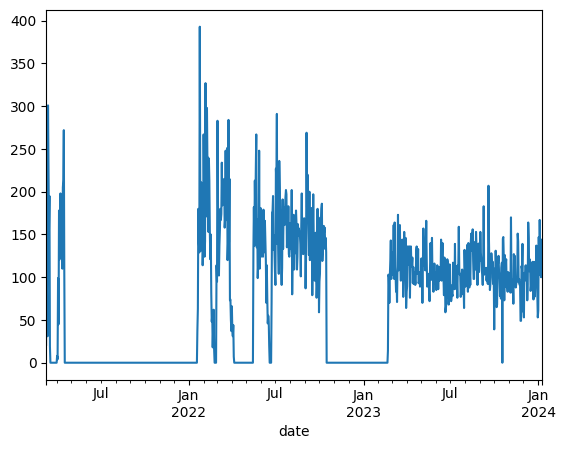

In [62]:
b = data["ID_60475eaac98ea30d727b7385"]
b["impressions"].plot();


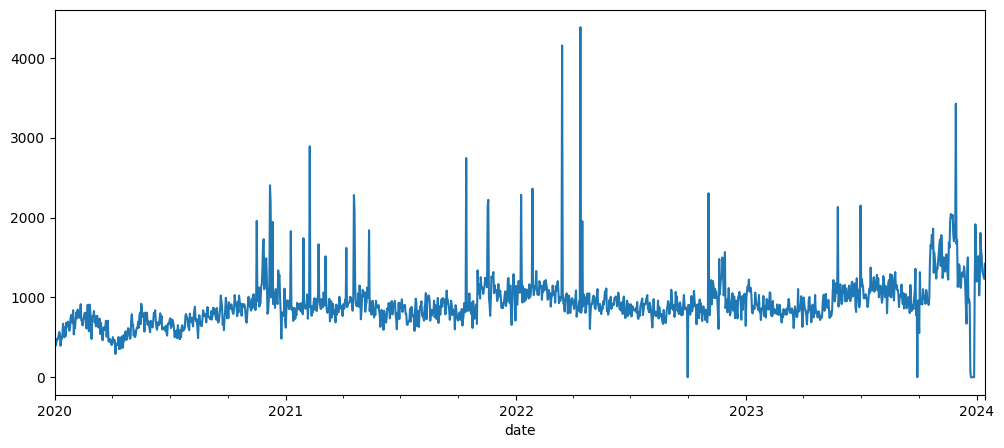

In [57]:
b["impressions"].plot(figsize=(12, 5));

## Explore

In [287]:
y.info()

AttributeError: 'dict' object has no attribute 'info'

### Missing values

In [36]:
y.isnull().sum()/len(y)

impressions           0.001380
clicks                0.001380
conversions           0.001380
ad_type               0.000000
ID                    0.000000
date                  0.000000
impression_share      0.000000
conversions_calls     0.033991
headline1_len         0.001380
headline2_len         0.001380
ad_description_len    0.001380
cost_zar              0.001380
dtype: float64

In [202]:
y.index.get_level_values("ID").unique()

Index(['ID_5da86e71bf5dee4cf5047046', 'ID_5e43c29e6279884e2827d894',
       'ID_5e4e7b480e374330ee151305', 'ID_5e8ad56cd4090270567b6c58',
       'ID_5e8b4f12d8709943490cd775', 'ID_5ebe73c4beb2212d415f6e56',
       'ID_5ee74f25f865a8154966b412', 'ID_5eebc5be7bcfa265595eb987',
       'ID_5f2ac3529666de2cdf5ae855', 'ID_5f3cdce8c0440e2c5902dd59',
       ...
       'ID_655c5cf8c1eb0b6291500174', 'ID_65649619b961e503bc796b2e',
       'ID_6565b6061f711967d4479b26', 'ID_65660b0c15962a6be05ec935',
       'ID_6567476a4a967518c623d506', 'ID_656747739b5c72023947f7c7',
       'ID_65687e2b40ea026fcc662a75', 'ID_6568807cbb9c4d235c5dd9a8',
       'ID_65a7bf329fa4627faf28390c', 'ID_65b0f65c7fe62e56c5593d55'],
      dtype='object', name='ID', length=185)

### Features cardinalities

In [40]:
y.select_dtypes("object").nunique()

ad_type       3
ID          185
date       1505
dtype: int64

#### <code>Call type</code>

In [18]:
y["call_type"].unique()

array([nan, 'Mobile click-to-call', 'Manually dialed'], dtype=object)

In [20]:
y["call_type"].isnull().value_counts(normalize=True)

call_type
True     0.872726
False    0.127274
Name: proportion, dtype: float64

#### <code>Call statut</code>

In [ ]:
y["call_status"].unique()

array([nan, 'Missed', 'Received'], dtype=object)

In [ ]:
mask = y["conversions_calls"] >1
y[mask & ~y["call_status"].isnull()].head(15)

,impressions,clicks,conversions,ad_type,ID,date,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,cost_zar
3662,366.0,30.0,2.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 14:19:48,125.0,2021-02-08 14:19:48,Ad,26.525021,2.0,2.0,2.0,13.0,3879.0
3663,366.0,30.0,2.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 12:58:38,316.0,2021-02-08 12:58:38,Ad,26.525021,2.0,2.0,2.0,13.0,3879.0
3664,366.0,30.0,2.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Missed,2021-02-08 11:27:58,0.0,2021-02-08 11:27:58,Ad,26.525021,2.0,2.0,2.0,13.0,3879.0
3665,303.0,26.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 14:19:48,125.0,2021-02-08 14:19:48,Ad,26.525021,2.0,2.0,5.0,11.0,2410.0
3666,303.0,26.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 12:58:38,316.0,2021-02-08 12:58:38,Ad,26.525021,2.0,2.0,5.0,11.0,2410.0
3667,303.0,26.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Missed,2021-02-08 11:27:58,0.0,2021-02-08 11:27:58,Ad,26.525021,2.0,2.0,5.0,11.0,2410.0
3668,129.0,12.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 14:19:48,125.0,2021-02-08 14:19:48,Ad,26.525021,2.0,2.0,2.0,10.0,1485.0
3669,129.0,12.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 12:58:38,316.0,2021-02-08 12:58:38,Ad,26.525021,2.0,2.0,2.0,10.0,1485.0
3670,129.0,12.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Missed,2021-02-08 11:27:58,0.0,2021-02-08 11:27:58,Ad,26.525021,2.0,2.0,2.0,10.0,1485.0
3671,75.0,4.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 14:19:48,125.0,2021-02-08 14:19:48,Ad,26.525021,2.0,2.0,3.0,13.0,549.0


In [27]:
y["call_status"].unique()

array([nan, 'Missed', 'Received'], dtype=object)

In [38]:
mask = y["conversions_calls"] >1
y[mask & ~y["call_status"].isnull()].head(15)

,impressions,clicks,conversions,ad_type,ID,date,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,cost_zar
3662,366.0,30.0,2.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 14:19:48,125.0,2021-02-08 14:19:48,Ad,26.525021,2.0,2.0,2.0,13.0,3879.0
3663,366.0,30.0,2.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 12:58:38,316.0,2021-02-08 12:58:38,Ad,26.525021,2.0,2.0,2.0,13.0,3879.0
3664,366.0,30.0,2.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Missed,2021-02-08 11:27:58,0.0,2021-02-08 11:27:58,Ad,26.525021,2.0,2.0,2.0,13.0,3879.0
3665,303.0,26.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 14:19:48,125.0,2021-02-08 14:19:48,Ad,26.525021,2.0,2.0,5.0,11.0,2410.0
3666,303.0,26.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 12:58:38,316.0,2021-02-08 12:58:38,Ad,26.525021,2.0,2.0,5.0,11.0,2410.0
3667,303.0,26.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Missed,2021-02-08 11:27:58,0.0,2021-02-08 11:27:58,Ad,26.525021,2.0,2.0,5.0,11.0,2410.0
3668,129.0,12.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 14:19:48,125.0,2021-02-08 14:19:48,Ad,26.525021,2.0,2.0,2.0,10.0,1485.0
3669,129.0,12.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 12:58:38,316.0,2021-02-08 12:58:38,Ad,26.525021,2.0,2.0,2.0,10.0,1485.0
3670,129.0,12.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Missed,2021-02-08 11:27:58,0.0,2021-02-08 11:27:58,Ad,26.525021,2.0,2.0,2.0,10.0,1485.0
3671,75.0,4.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2021-02-08,Received,2021-02-08 14:19:48,125.0,2021-02-08 14:19:48,Ad,26.525021,2.0,2.0,3.0,13.0,549.0


In [32]:
y["conversions_calls"].unique()

array([ 0.,  1.,  2.,  3.,  4., nan,  5.,  8.,  6.,  7.])

#### <code>Start time </code>

In [40]:
y[~y["start_time"].isnull()]

,impressions,clicks,conversions,ad_type,ID,date,call_status,start_time,duration,end_time,display_location,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,cost_zar
2596,291.0,52.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-10-29,Missed,2020-10-29 08:11:17,0.0,2020-10-29 08:11:17,Ad,24.507694,0.0,2.0,2.0,13.0,5567.0
2597,182.0,13.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-10-29,Missed,2020-10-29 08:11:17,0.0,2020-10-29 08:11:17,Ad,24.507694,0.0,2.0,5.0,11.0,1505.0
2598,143.0,13.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-10-29,Missed,2020-10-29 08:11:17,0.0,2020-10-29 08:11:17,Ad,24.507694,0.0,2.0,2.0,10.0,1575.0
2599,42.0,9.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-10-29,Missed,2020-10-29 08:11:17,0.0,2020-10-29 08:11:17,Ad,24.507694,0.0,2.0,2.0,13.0,1181.0
2600,85.0,5.0,0.0,EXPANDED_TEXT_AD,ID_5da86e71bf5dee4cf5047046,2020-10-29,Missed,2020-10-29 08:11:17,0.0,2020-10-29 08:11:17,Ad,24.507694,0.0,2.0,3.0,13.0,519.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289311,68.0,3.0,0.0,RESPONSIVE_SEARCH_AD,ID_6568807cbb9c4d235c5dd9a8,2023-12-20,Missed,2023-12-20 19:00:58,0.0,2023-12-20 19:00:58,AD,9.990000,0.0,4.0,4.0,12.0,2856.0
289312,68.0,3.0,0.0,RESPONSIVE_SEARCH_AD,ID_6568807cbb9c4d235c5dd9a8,2023-12-20,Missed,2023-12-20 18:52:02,0.0,2023-12-20 18:52:02,AD,9.990000,0.0,4.0,4.0,12.0,2856.0
289321,71.0,3.0,1.0,RESPONSIVE_SEARCH_AD,ID_6568807cbb9c4d235c5dd9a8,2023-12-27,Received,2023-12-27 15:24:34,96.0,2023-12-27 15:26:10,AD,9.990000,1.0,4.0,4.0,12.0,2247.0
289348,104.0,5.0,0.0,RESPONSIVE_SEARCH_AD,ID_6568807cbb9c4d235c5dd9a8,2024-01-18,Missed,2024-01-18 20:28:22,0.0,2024-01-18 20:28:22,AD,11.639079,0.0,4.0,4.0,12.0,7840.0


#### <code>Display Location</code>

In [50]:
y["display_location"].unique()

array([nan, 'Ad', 'AD', 'Website', 'LANDING_PAGE'], dtype=object)

In [62]:
mask_2 = y["display_location"]=="Website"

y[y["display_location"].isnull()][["ad_type", "display_location"]].iloc[21:50]

,ad_type,display_location
21,EXPANDED_TEXT_AD,NaN
22,EXPANDED_TEXT_AD,NaN
23,EXPANDED_TEXT_AD,NaN
24,EXPANDED_TEXT_AD,NaN
25,EXPANDED_TEXT_AD,NaN
26,EXPANDED_TEXT_AD,NaN
27,EXPANDED_TEXT_AD,NaN
28,EXPANDED_TEXT_AD,NaN
29,EXPANDED_TEXT_AD,NaN
30,EXPANDED_TEXT_AD,NaN


#### <code> Ad type</code>

In [16]:
y["ad_type"].nunique()

3

In [37]:
y["ad_type"].unique()

array(['EXPANDED_TEXT_AD', 'EXPANDED_DYNAMIC_SEARCH_AD',
       'RESPONSIVE_SEARCH_AD'], dtype=object)

In [38]:
y["ad_type"].value_counts(normalize=True)

ad_type
EXPANDED_TEXT_AD              0.512210
RESPONSIVE_SEARCH_AD          0.334496
EXPANDED_DYNAMIC_SEARCH_AD    0.153294
Name: proportion, dtype: float64

In [39]:
y["ad_type"].isnull().value_counts(normalize=True)

ad_type
False    1.0
Name: proportion, dtype: float64

### Numeric values

|impression_share|
|conversions_calls|
|headline1_len|
|headline2_len|
|ad_description_len|
|cost_zar|


#### Conversion calls

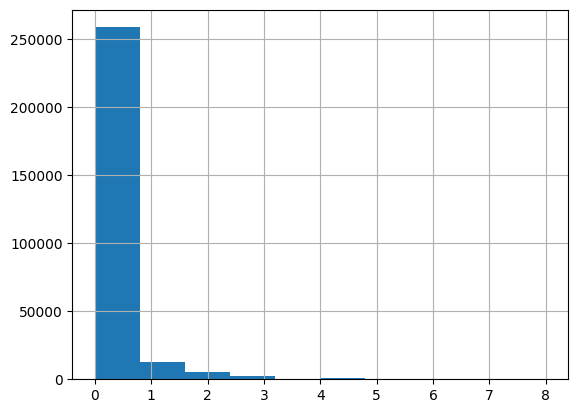

In [45]:
y["conversions_calls"].hist();

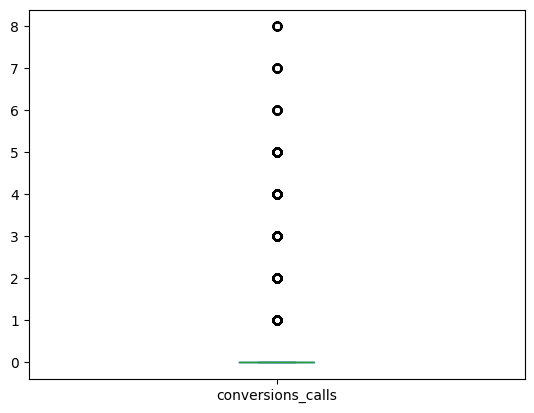

In [46]:
y["conversions_calls"].plot(kind="box");

#### headline1_len

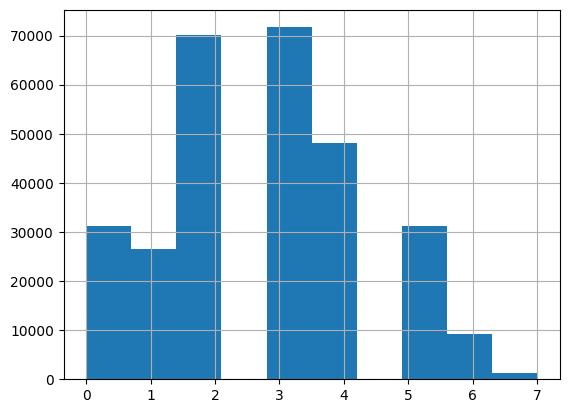

In [47]:
y["headline1_len"].hist();

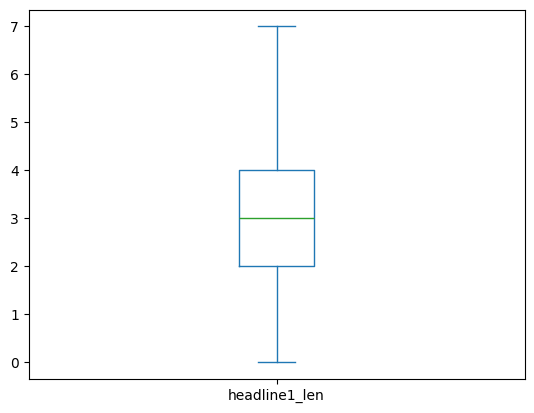

In [48]:
y["headline1_len"].plot(kind="box");

#### headline2_len

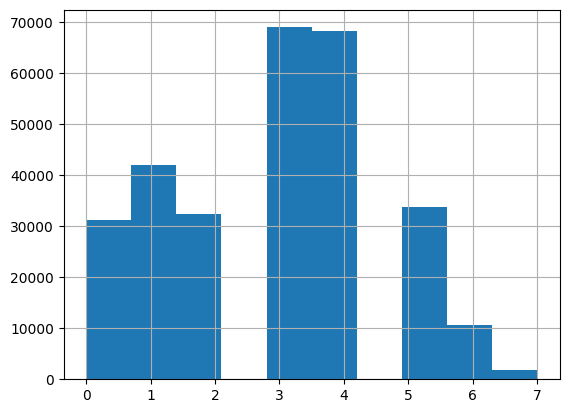

In [49]:
y["headline2_len"].hist();

<Axes: >

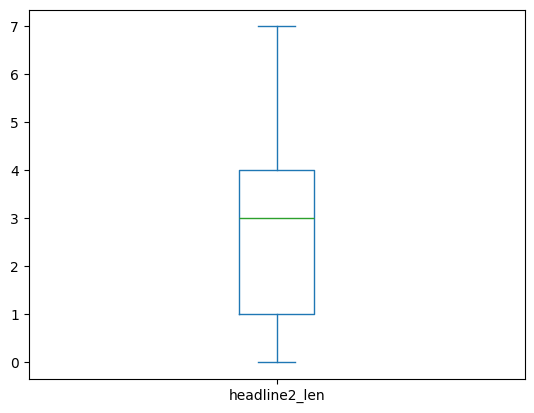

In [50]:
y["headline2_len"].plot(kind="box");

#### ad_description_len

<Axes: >

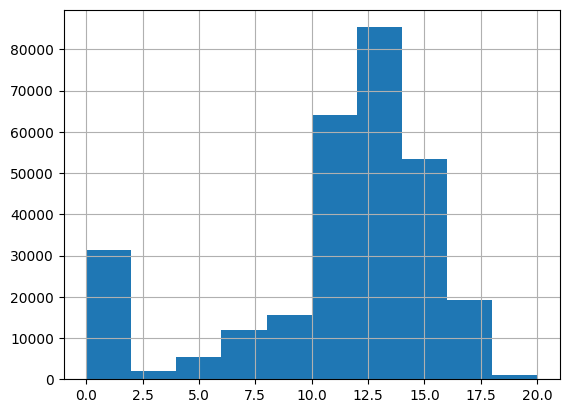

In [51]:
y["ad_description_len"].hist();

<Axes: >

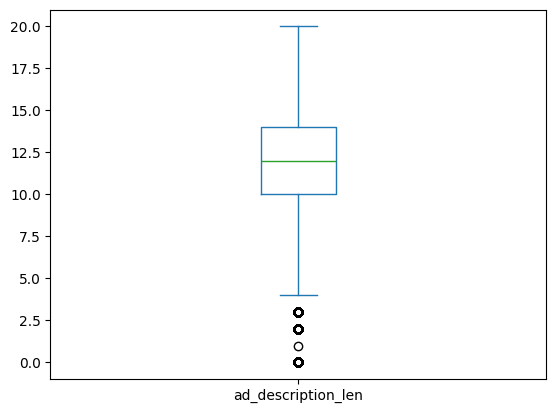

In [52]:
y["ad_description_len"].plot(kind="box");

#### Cost_zar

<Axes: >

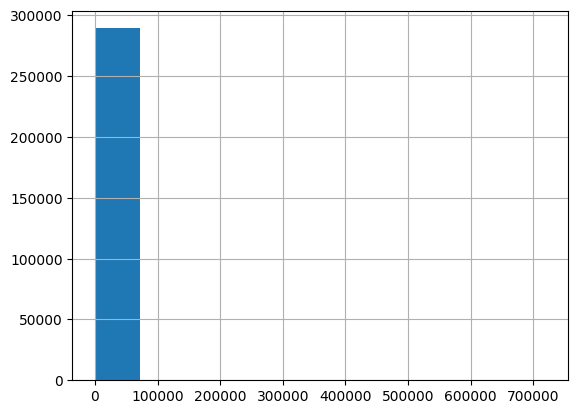

In [53]:
y["cost_zar"].hist();

<Axes: >

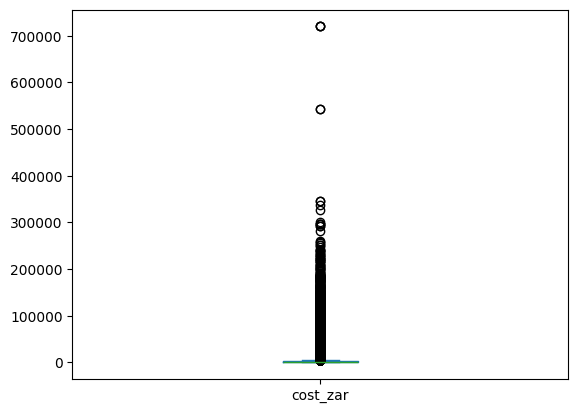

In [54]:
y["cost_zar"].plot(kind="box")

#### Correlation matrix

In [13]:
y["ID"].unique()

ID
ID_5da86e71bf5dee4cf5047046    [ID_5da86e71bf5dee4cf5047046]
ID_5e43c29e6279884e2827d894    [ID_5e43c29e6279884e2827d894]
ID_5e4e7b480e374330ee151305    [ID_5e4e7b480e374330ee151305]
ID_5e8ad56cd4090270567b6c58    [ID_5e8ad56cd4090270567b6c58]
ID_5e8b4f12d8709943490cd775    [ID_5e8b4f12d8709943490cd775]
                                           ...              
ID_656747739b5c72023947f7c7    [ID_656747739b5c72023947f7c7]
ID_65687e2b40ea026fcc662a75    [ID_65687e2b40ea026fcc662a75]
ID_6568807cbb9c4d235c5dd9a8    [ID_6568807cbb9c4d235c5dd9a8]
ID_65a7bf329fa4627faf28390c    [ID_65a7bf329fa4627faf28390c]
ID_65b0f65c7fe62e56c5593d55    [ID_65b0f65c7fe62e56c5593d55]
Name: ID, Length: 185, dtype: object

In [93]:
corr = {}

for ID, group in y:
    corr[ID]=group.select_dtypes("number").corr()


ValueError: too many values to unpack (expected 2)

In [222]:
y["ID_5da86e71bf5dee4cf5047046"].columns

Index(['impressions', 'clicks', 'conversions', 'ad_type', 'ID',
       'impression_share', 'conversions_calls', 'headline1_len',
       'headline2_len', 'ad_description_len', 'cost_zar'],
      dtype='object')

In [5]:
group_1 = y["ID_5f3cdce8c0440e2c5902dd59"]
group_1 = group_1[mask := group_1.index.get_level_values("ad_type")=="EXPANDED_DYNAMIC_SEARCH_AD"]

In [6]:
gp_exog = group_1.drop(columns='clicks')
gp_endo = group_1["clicks"]

In [105]:
group_1.iloc[1100:1200]

,impressions,clicks,conversions,conversions_calls
date,,,,
2023-09-30,31.0,9.0,0.0,0.0
2023-10-01,23.0,7.0,0.0,0.0
2023-10-02,28.0,5.0,0.0,0.0
2023-10-03,41.0,7.0,0.0,0.0
2023-10-04,24.0,5.0,0.0,0.0
...,...,...,...,...
2024-01-03,44.0,5.0,0.0,0.0
2024-01-04,52.0,11.0,0.0,0.0
2024-01-05,51.0,7.0,0.0,0.0


In [7]:
group_1.index = group_1.index.droplevel((0,1))


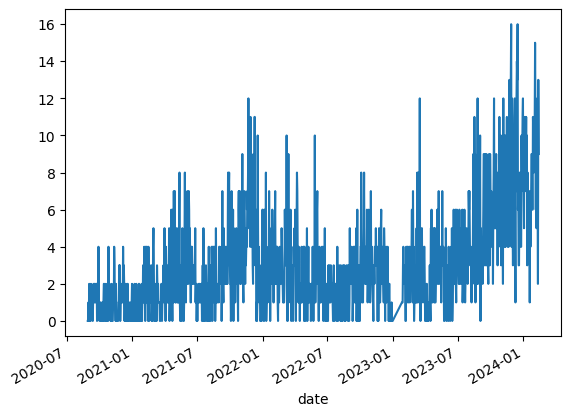

In [106]:
group_1["clicks"].plot();

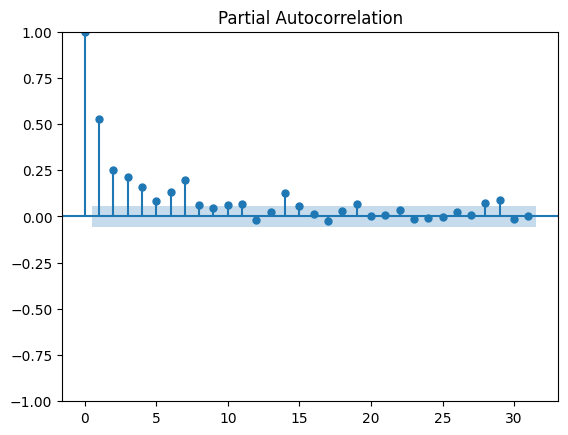

In [9]:
plot_pacf(gp_endo);

In [29]:
gp_exog.head()

impressions  \
ID                          ad_type                    date                      
ID_5da86e71bf5dee4cf5047046 EXPANDED_DYNAMIC_SEARCH_AD 2020-01-17        102.0   
                                                       2020-01-18        124.0   
                                                       2020-01-19        228.0   
                                                       2020-01-20        235.0   
                                                       2020-01-21        186.0   

                                                                   conversions  
ID                          ad_type                    date                     
ID_5da86e71bf5dee4cf5047046 EXPANDED_DYNAMIC_SEARCH_AD 2020-01-17          0.0  
                                                       2020-01-18          0.0  
                                                       2020-01-19          0.0  
                                                       2020-01-20          0.0  
                                                       2020-01-21          0.0

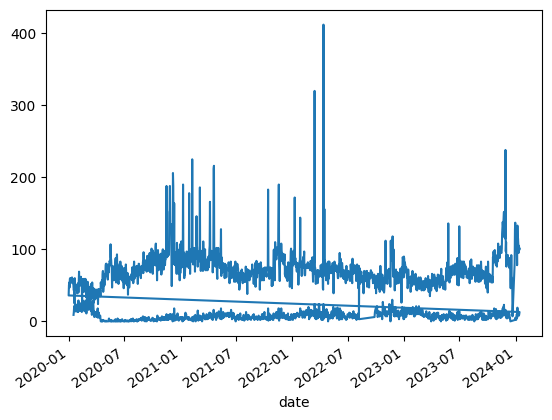

In [60]:
gp_endo.index=gp_endo.index.droplevel((0, 1))
gp_endo.plot()
plt.xticks(rotation = 35);

In [152]:
gp_exog["impressions"].corr(gp_endo)

0.9141116324829025

In [131]:
gp_endo.head()

date
2020-01-01    15.0
2020-01-01     8.0
2020-01-01     8.0
2020-01-01     4.0
2020-01-01     1.0
Name: clicks, dtype: float64

In [135]:
exog_ma = gp_exog.select_dtypes("number").corr()
exog_ma.style.background_gradient()

,impressions,conversions,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,cost_zar
impressions,1.000000,0.054599,-0.082806,0.003663,0.180375,0.333388,0.059715,0.833521
conversions,0.054599,1.000000,0.007747,0.288160,-0.009867,0.029313,-0.002572,0.043207
impression_share,-0.082806,0.007747,1.000000,0.029154,-0.278248,0.017324,0.240317,-0.170059
conversions_calls,0.003663,0.288160,0.029154,1.000000,-0.026909,-0.013477,0.018142,-0.002114
headline1_len,0.180375,-0.009867,-0.278248,-0.026909,1.000000,0.278094,0.192975,0.180058
headline2_len,0.333388,0.029313,0.017324,-0.013477,0.278094,1.000000,0.043684,0.188557
ad_description_len,0.059715,-0.002572,0.240317,0.018142,0.192975,0.043684,1.000000,0.012111
cost_zar,0.833521,0.043207,-0.170059,-0.002114,0.180058,0.188557,0.012111,1.000000


In [178]:
group_1_corr = round(group_1.select_dtypes("number").corr(),6)
group_1_corr.style.background_gradient()

,impressions,clicks,conversions,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,cost_zar
impressions,1.000000,0.914112,0.054599,-0.082806,0.003663,0.180375,0.333388,0.059715,0.833521
clicks,0.914112,1.000000,0.060477,0.018729,-0.001890,0.108921,0.274207,0.042369,0.823631
conversions,0.054599,0.060477,1.000000,0.007747,0.288160,-0.009867,0.029313,-0.002572,0.043207
impression_share,-0.082806,0.018729,0.007747,1.000000,0.029154,-0.278248,0.017324,0.240317,-0.170059
conversions_calls,0.003663,-0.001890,0.288160,0.029154,1.000000,-0.026909,-0.013477,0.018142,-0.002114
headline1_len,0.180375,0.108921,-0.009867,-0.278248,-0.026909,1.000000,0.278094,0.192975,0.180058
headline2_len,0.333388,0.274207,0.029313,0.017324,-0.013477,0.278094,1.000000,0.043684,0.188557
ad_description_len,0.059715,0.042369,-0.002572,0.240317,0.018142,0.192975,0.043684,1.000000,0.012111
cost_zar,0.833521,0.823631,0.043207,-0.170059,-0.002114,0.180058,0.188557,0.012111,1.000000


In [ ]:
for col in exog_ma.columns:
    test_correlated_cols = exog_ma[abs(exog_ma[col]) >= 0.7].index.tolist()
    
    try:
        test_correlated_cols.remove(col)  # Avoid removing the variable itself
    except ValueError:
        continue
    
    if len(test_correlated_cols) !=0:  # Check if 'correlated_cols' is not empty
        min_corr = round(min(gp_exog[test_correlated_cols[0]].corr(gp_endo), abs(gp_exog[col].corr(gp_endo))), 6)

#index = group_1_corr["clicks"].index[group_1_corr["clicks"]==min_corr]


In [326]:
group_1 = y["ID_5e8ad56cd4090270567b6c58"]
gp = remove_correlated_variables(group_1)
gp

,impressions,clicks,conversions,ad_type,ID,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len
date,,,,,,,,,,
2020-04-08,102.0,7.0,0.0,EXPANDED_TEXT_AD,ID_5e8ad56cd4090270567b6c58,24.696467,0.0,2.0,3.0,13.0
2020-04-08,40.0,2.0,0.0,EXPANDED_TEXT_AD,ID_5e8ad56cd4090270567b6c58,24.696467,0.0,2.0,3.0,13.0
2020-04-08,25.0,1.0,0.0,EXPANDED_TEXT_AD,ID_5e8ad56cd4090270567b6c58,24.696467,0.0,2.0,3.0,14.0
2020-04-09,159.0,8.0,0.0,EXPANDED_TEXT_AD,ID_5e8ad56cd4090270567b6c58,46.762444,0.0,2.0,3.0,13.0
2020-04-09,61.0,5.0,0.0,EXPANDED_TEXT_AD,ID_5e8ad56cd4090270567b6c58,46.762444,0.0,2.0,3.0,13.0
...,...,...,...,...,...,...,...,...,...,...
2024-02-13,227.0,12.0,0.0,RESPONSIVE_SEARCH_AD,ID_5e8ad56cd4090270567b6c58,10.027469,0.0,2.0,3.0,11.0
2024-02-13,33.0,5.0,0.0,RESPONSIVE_SEARCH_AD,ID_5e8ad56cd4090270567b6c58,10.027469,0.0,5.0,3.0,14.0
2024-02-13,47.0,4.0,0.0,RESPONSIVE_SEARCH_AD,ID_5e8ad56cd4090270567b6c58,10.027469,0.0,3.0,4.0,15.0


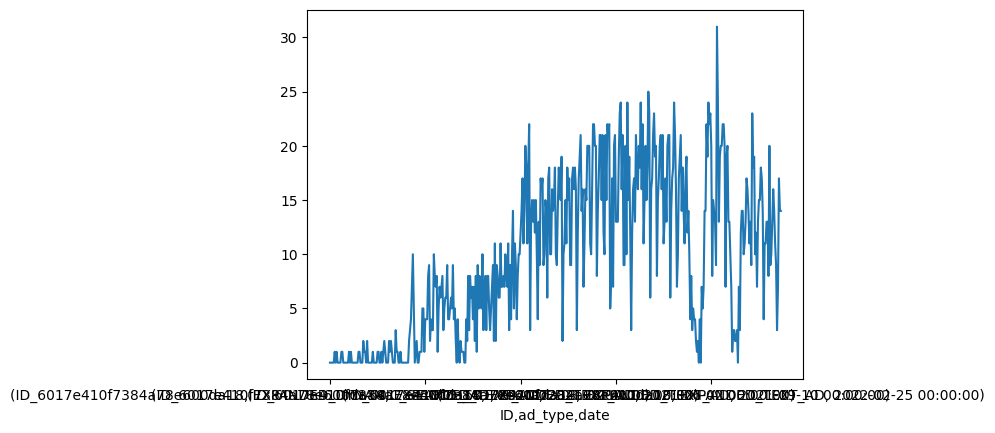

In [31]:
group_1 = y["ID_6017e410f7384a78e600da18"]
group_1["clicks"].plot();

In [343]:
y.keys()

dict_keys(['ID_5da86e71bf5dee4cf5047046', 'ID_5e43c29e6279884e2827d894', 'ID_5e4e7b480e374330ee151305', 'ID_5e8ad56cd4090270567b6c58', 'ID_5e8b4f12d8709943490cd775', 'ID_5ebe73c4beb2212d415f6e56', 'ID_5ee74f25f865a8154966b412', 'ID_5eebc5be7bcfa265595eb987', 'ID_5f2ac3529666de2cdf5ae855', 'ID_5f3cdce8c0440e2c5902dd59', 'ID_5f436d32c620230547446af4', 'ID_5f439a30fcc0f575b674bb95', 'ID_5f4514323f494e4a2a5eb273', 'ID_5f9e5f1c691b48189c22aac6', 'ID_5fa3dab4394cd16b000ec5fc', 'ID_5fc1263767e20c14590941ed', 'ID_5fd88b10425b32098417a3d4', 'ID_600d8eaaf5c7660c0b1f0773', 'ID_6017e410f7384a78e600da18', 'ID_602b729b3f4128452c1c2f64', 'ID_602cfab1d7768d79aa6629b4', 'ID_604752a9861a02467a27c054', 'ID_60475eaac98ea30d727b7385', 'ID_6047b0d4c59eff5af82a57ee', 'ID_606f34aef59df516866d0ab1', 'ID_6083bd8472c70c3d1869bc68', 'ID_608a6897d96a507cd36c935d', 'ID_608a6ad834a94a4eb8742899', 'ID_60e556f789173d61d07e3294', 'ID_60e5572b44311c0aa4513107', 'ID_60ed537e880be55ca17d2cb6', 'ID_60f0802ede929401f94e50b5

### Split

In [7]:
target = "clicks"
X = {}
y = {}

for ID, group in data.items():
    X[ID] = group.drop(columns = target)
    y[ID] = group[target]

In [8]:
X_trains, X_tests ={}, {}
y_trains, y_tests = {}, {}

In [9]:
for ID, group in X.items():
    cut_off = int(len(group)*0.9)
    X_trains[ID] = group.iloc[:cut_off]
    X_tests[ID] = group.iloc[cut_off:]

for ID, group in y.items():
    cut_off = int(len(group)*0.9)
    y_trains[ID] = group.iloc[:cut_off]
    y_tests[ID] = group.iloc[cut_off:]

# Model

In [86]:
data_length = {}
for ID, group in data.items():
    data_length[ID] = len(group)

pd.DataFrame({"len": data_length.values(), "ID": data_length.keys()}).sort_values("len", ascending = False)

,len,ID
0,1475,ID_5da86e71bf5dee4cf5047046
1,1463,ID_5e43c29e6279884e2827d894
3,1407,ID_5e8ad56cd4090270567b6c58
2,1365,ID_5e4e7b480e374330ee151305
6,1335,ID_5ee74f25f865a8154966b412
...,...,...
143,30,ID_64cce13a065233199d450754
147,27,ID_64e75947276de33b8665a516
183,23,ID_65a7bf329fa4627faf28390c
167,22,ID_65278bc176ff2b5ae5093c89


## Trying with one ID 

ID_5da86e71bf5dee4cf5047046

In [140]:
work_data = data["ID_5da86e71bf5dee4cf5047046"]
work_data.head()

,impressions,clicks,EXPANDED_TEXT_AD,RESPONSIVE_SEARCH_AD,EXPANDED_DYNAMIC_SEARCH_AD
date,,,,,
2020-01-01,393,36,1,0,0
2020-01-02,395,50,1,0,0
2020-01-03,404,54,1,0,0
2020-01-04,476,47,1,0,0
2020-01-05,466,59,1,0,0


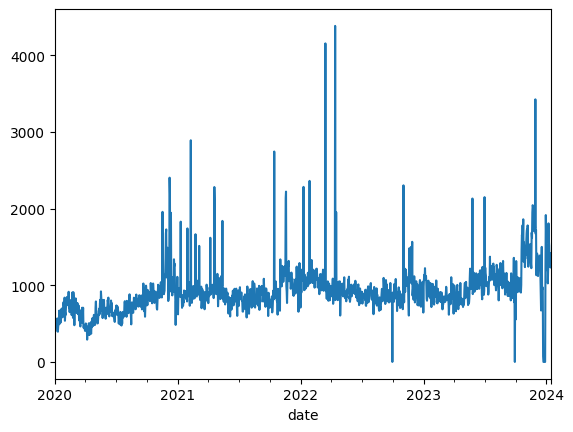

In [124]:
work_data["impressions"].plot();

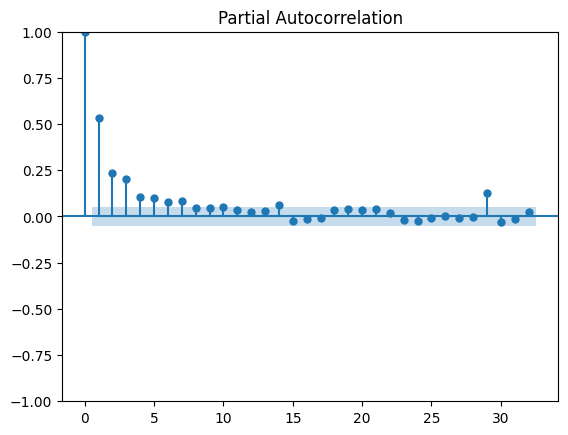

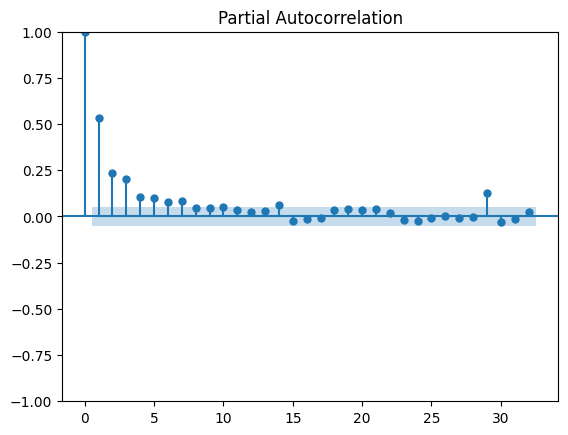

In [97]:
plot_pacf(work_data["impressions"])

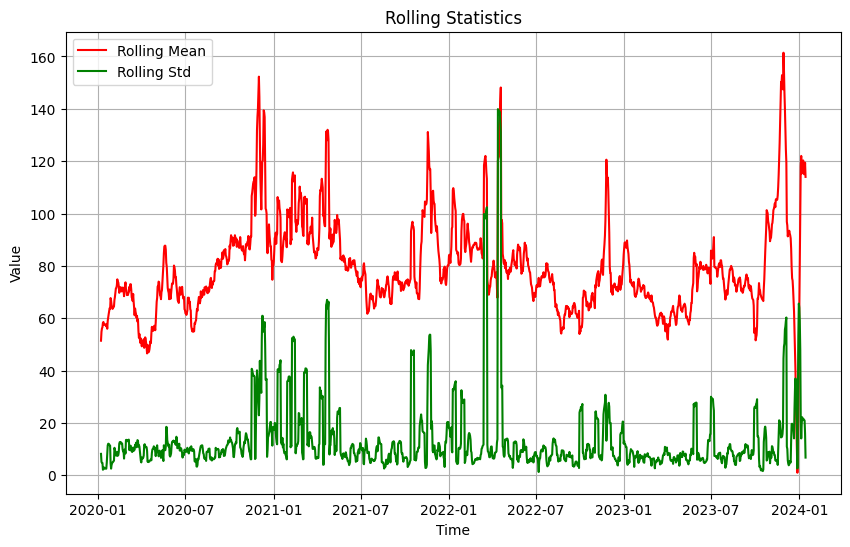

In [127]:
rolling_mean = work_data["clicks"].rolling(window=7).mean()
rolling_std = work_data["clicks"].rolling(window=7).std()

# Plot rolling statistics
plt.figure(figsize=(10, 6))
#plt.plot(work_data, label='Original Data')
plt.plot(rolling_mean, label='Rolling Mean', color='red')
plt.plot(rolling_std, label='Rolling Std', color='green')
plt.title('Rolling Statistics')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

In [141]:
def difference(data, target):
    
    diff = data.drop(columns = [target, "EXPANDED_TEXT_AD", "RESPONSIVE_SEARCH_AD", "EXPANDED_DYNAMIC_SEARCH_AD"]).diff().fillna(0)
    dicto = {}
    
    for col in list(diff.columns):
        dicto[col] = f"{col}_diff"
    
    diff = diff.rename(columns=dicto)
    
    return pd.concat([data, diff], axis = 1)

In [142]:
work_data= difference(work_data, "clicks")

In [143]:
work_data.head()

,impressions,clicks,EXPANDED_TEXT_AD,RESPONSIVE_SEARCH_AD,EXPANDED_DYNAMIC_SEARCH_AD,impressions_diff
date,,,,,,
2020-01-01,393,36,1,0,0,0.0
2020-01-02,395,50,1,0,0,2.0
2020-01-03,404,54,1,0,0,9.0
2020-01-04,476,47,1,0,0,72.0
2020-01-05,466,59,1,0,0,-10.0


In [149]:
work_data.drop(columns = ["EXPANDED_TEXT_AD", "RESPONSIVE_SEARCH_AD", "EXPANDED_DYNAMIC_SEARCH_AD"]).select_dtypes("number").corr().style.background_gradient()

,impressions,clicks,impressions_diff
impressions,1.000000,0.828270,0.481889
clicks,0.828270,1.000000,0.436354
impressions_diff,0.481889,0.436354,1.000000


In [150]:
target = "clicks"
Xwork = work_data.drop(columns = target)
ywork = work_data[target]

In [151]:
cut_off = int(len(X_work)*0.8)

Xwork_train, ywork_train = Xwork.iloc[:cut_off], ywork.iloc[:cut_off]
Xwork_test, ywork_test = Xwork.iloc[cut_off:], ywork.iloc[cut_off:]

### Baseline

In [152]:
ywork_baseline = [ywork_train.mean()] * len(ywork_train)
mse = mean_squared_error(ywork_train, ywork_baseline)
ywork.mean(), mse

(79.39186440677966, 651.5876551278368)

In [165]:
p_params = range(28, 31, 1)
q_params =  range(0, 3, 1)

In [166]:
mse_grid={}

for p in p_params:

    mse_grid[p] = list()

    for q in q_params:
        group_order = (p, 0, q)
        start_time = time.time()
        model = ARIMA(endog = ywork_train, exog = Xwork_train, order=group_order, trend='n').fit()
        elapsed_time = round(time.time() - start_time, 2)
        print(f"Trained ARIMAX {group_order} in {elapsed_time} seconds.")

        ywork_pred = model.predict()
        
        mse = mean_squared_error(ywork_train, ywork_pred)
        
        mse_grid[p].append(mse)

print("--->")
mse_grid


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (28, 0, 0) in 69.89 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (28, 0, 1) in 65.87 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (28, 0, 2) in 81.28 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (29, 0, 0) in 74.17 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (29, 0, 1) in 72.88 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (29, 0, 2) in 72.79 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (30, 0, 0) in 72.12 seconds.
Trained ARIMAX (30, 0, 1) in 75.5 seconds.


c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Trained ARIMAX (30, 0, 2) in 82.21 seconds.
--->


{28: [111.06472735208145, 111.09754537592735, 111.10713670640702],
 29: [110.82353446437133, 110.84675597865889, 110.85230254361626],
 30: [110.77908582783887, 110.79406093112948, 110.800958047628]}

In [167]:
m= pd.DataFrame(mse_grid)
m

,28,29,30
0,111.064727,110.823534,110.779086
1,111.097545,110.846756,110.794061
2,111.107137,110.852303,110.800958


In [168]:
m.min().sort_values()

30    110.779086
29    110.823534
28    111.064727
dtype: float64

In [164]:
m.min().sort_values()

28    111.064727
25    111.505399
7     111.525596
22    111.584797
1     111.965035
19    112.016583
16    112.287336
13    112.880039
4     113.106844
10    113.825109
dtype: float64

<Axes: >

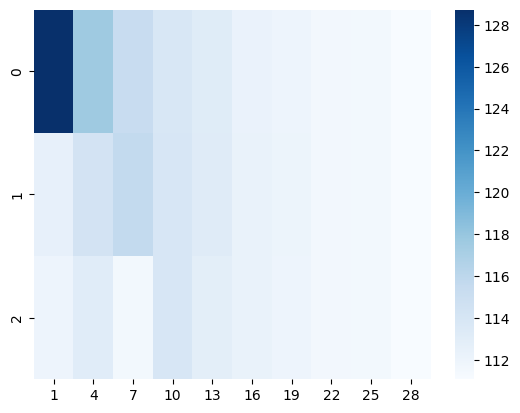

In [161]:
sns.heatmap(m, cmap="Blues")

In [11]:
all_mse = {}

for (ID, y_pred), y_train in zip(y_baselines.items(), y_trains.values()):
    all_mse[ID] = mean_squared_error(y_train, y_pred)

In [305]:
all_mse

{'ID_5da86e71bf5dee4cf5047046': 1336.5606222893152,
 'ID_5e43c29e6279884e2827d894': 15.529819797274753,
 'ID_5e4e7b480e374330ee151305': 27.216807064731626,
 'ID_5e8ad56cd4090270567b6c58': 457.38576816524784,
 'ID_5e8b4f12d8709943490cd775': 16.16398064033224,
 'ID_5ebe73c4beb2212d415f6e56': 21.574516314179643,
 'ID_5ee74f25f865a8154966b412': 357.3388600638855,
 'ID_5eebc5be7bcfa265595eb987': 49.1298198812016,
 'ID_5f2ac3529666de2cdf5ae855': 29.39359473791708,
 'ID_5f3cdce8c0440e2c5902dd59': 986.8299712441432,
 'ID_5f436d32c620230547446af4': 0.8395061728395062,
 'ID_5f439a30fcc0f575b674bb95': 519.746828143022,
 'ID_5f4514323f494e4a2a5eb273': 47.71159499906429,
 'ID_5f9e5f1c691b48189c22aac6': 74.22379447334157,
 'ID_5fa3dab4394cd16b000ec5fc': 701.9394427957458,
 'ID_5fc1263767e20c14590941ed': 1.167799663885903,
 'ID_5fd88b10425b32098417a3d4': 36.27396005559831,
 'ID_600d8eaaf5c7660c0b1f0773': 7013.8570457580045,
 'ID_6017e410f7384a78e600da18': 56.178866626992004,
 'ID_602b729b3f4128452c1c

### Iterate

In [30]:
# Define the parameter grid
p_params = range(1, 30, 5),
q_params =  range(0, 3, 1)

In [64]:
all_mse_grid = {} # mse_grid by key

for (ID, X_train), y_train in zip(X_trains.items(), y_trains.values()):
    
    mse_grid={}

    for p in p_params:

        mse_grid[p] = list()

        for q in q_params:
            group_order = (p, 0, q)
            start_time = time.time()
            model = SARIMAX(endog = y_train, exog = X_train, order=group_order, trend='n').fit()
            elapsed_time = round(time.time() - start_time, 2)
            y_pred = model.predict()
            mse = mean_squared_error(y_train, y_pred)
            mse_grid[p].append((mse, elapsed_time))
    
    all_mse_grid[ID] = mse_grid



c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\22967\Documents\Python env\Data_Analyst_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic 

LinAlgError: LU decomposition error.

In [21]:
best_params = {}
best_models = {}

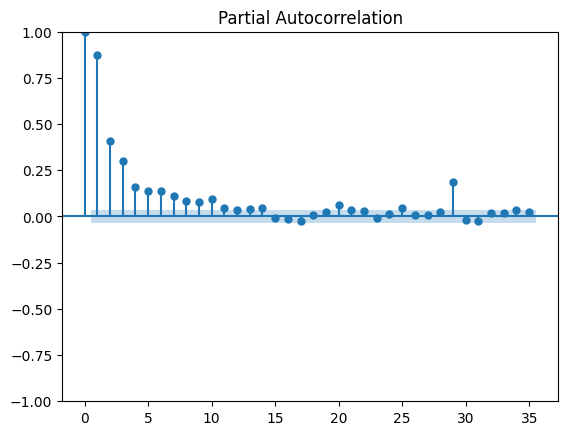

In [38]:
plot_pacf(b["clicks"]);

### Evaluate

# Communication or predictions